# Stage 2 — Model comparison (Logistic Regression, Random Forest, SVC, MLP)
This notebook continues from Stage 1 preprocessing and feature engineering for the Pima Indians Diabetes dataset.
We:
- data url = "https://raw.githubusercontent.com/nafis-git/projects_ML/main/data/diabetes.csv"
- Repeat your Stage 1 preprocessing: replace zeros by `NaN` for selected features, fill medians **by Outcome**
- Keep / create feature engineering: `BMI_CAT`, `INSULIN_CAT`, and a new `AGE_BIN`
- Standard scale numeric features, one-hot encode categorical features
- Train & compare these models (5-fold Stratified CV):
  - LogisticRegression
  - RandomForestClassifier
  - SVC (RBF kernel with probability=True)
  - MLPClassifier
- Produce per-model CV scores, confusion matrix, ROC and Precision–Recall curves, and a summary table

In [20]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
                             auc, log_loss)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform as sp_uniform
import time
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')
RND = 42


In [2]:
# load dataset
data_path = "https://raw.githubusercontent.com/nafis-git/projects_ML/main/data/diabetes.csv"
df = pd.read_csv(data_path)
print("Data shape:", df.shape)
df.head()


Data shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:

df.info()
df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [4]:

# Replace physiologically-impossible zeros with NaN for these columns
cols_zero_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_zero_missing:
    # Some datasets use slightly different capitalization; ensure exact names
    if c in df.columns:
        df[c] = df[c].replace(0, np.nan)

# Show % missing
missing_values = (df.isnull().sum() / len(df) * 100).round(2)
print("Missing (percent):\n", missing_values[missing_values > 0])


Missing (percent):
 Glucose           0.65
BloodPressure     4.56
SkinThickness    29.56
Insulin          48.70
BMI               1.43
dtype: float64


In [5]:
#  fill NaNs by median per Outcome
# compute medians by Outcome for columns with missing values
for col in cols_zero_missing:
    if col in df.columns:
        medians = df[[col,'Outcome']].groupby('Outcome')[col].median()
        # fill for each Outcome
        for outcome_val in medians.index:
            median_val = medians.loc[outcome_val]
            df.loc[(df['Outcome'] == outcome_val) & (df[col].isnull()), col] = median_val

# confirm no remaining NaNs in those columns
print(df[cols_zero_missing].isnull().sum())


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


In [6]:
# Feature engineering: preserve your BMI_CAT and INSULIN_CAT, and add AGE_BIN
def set_bmi(x):
    if x < 18.5:
        return "Under Weight"
    elif 18.5 <= x <= 24.9:
        return "Healthy"
    elif 25 <= x <= 29.9:
        return "Over Weight"
    else:
        return "Obese"

def set_insulin(x):
    # Normal range chosen from your rule (16..166)
    return "Normal" if (x >= 16 and x <= 166) else "Abnormal"

def set_age_bin(age):
    # Simple bins: <30, 30-50, >50 — you can adjust thresholds if wanted
    if age < 30:
        return "Young"
    elif 30 <= age <= 50:
        return "Middle"
    else:
        return "Senior"

# create features only if columns exist
if 'BMI' in df.columns:
    df['BMI_CAT'] = df['BMI'].apply(set_bmi)
if 'Insulin' in df.columns:
    df['INSULIN_CAT'] = df['Insulin'].apply(set_insulin)
if 'Age' in df.columns:
    df['AGE_BIN'] = df['Age'].apply(set_age_bin)

# Show counts
for new_col in ['BMI_CAT','INSULIN_CAT','AGE_BIN']:
    if new_col in df.columns:
        print(new_col, "value counts:")
        print(df[new_col].value_counts())
        print()


BMI_CAT value counts:
BMI_CAT
Obese           483
Over Weight     179
Healthy         102
Under Weight      4
Name: count, dtype: int64

INSULIN_CAT value counts:
INSULIN_CAT
Normal      496
Abnormal    272
Name: count, dtype: int64

AGE_BIN value counts:
AGE_BIN
Young     396
Middle    291
Senior     81
Name: count, dtype: int64



In [7]:
# Prepare X and y, list numeric and categorical columns
y = df['Outcome'].copy()
X = df.drop(columns=['Outcome'])

# Decide numeric cols: original numeric columns (excluding newly created categories)
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
# Exclude possible ID or similar if present (none expected)
# Decide categorical columns: the engineered ones + any object dtype
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# Ensure cat features are included
for c in ['BMI_CAT','INSULIN_CAT','AGE_BIN']:
    if c in X.columns and c not in cat_cols:
        cat_cols.append(c)

print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical columns: ['BMI_CAT', 'INSULIN_CAT', 'AGE_BIN']


In [9]:
# Preprocessing pipeline:
# - OneHotEncode categorical features
# - StandardScale numeric features
from sklearn.pipeline import make_pipeline

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# Fit-transform once to inspect final feature shape
X_prep = preprocessor.fit_transform(X)
# get final feature names (approximate)
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_cols = []
if cat_cols:
    # build feature names from OHE
    ohe_cols = ohe.get_feature_names_out(cat_cols).tolist()

final_feature_names = numeric_cols + ohe_cols
print("Final feature count:", len(final_feature_names))


Final feature count: 14


In [10]:
#Prepare Stratified K-Fold and models
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, random_state=RND, solver='liblinear'),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RND),
    "SVC_RBF": SVC(kernel='rbf', probability=True, random_state=RND),
    "MLP": MLPClassifier(hidden_layer_sizes=(80,), max_iter=1000, random_state=RND)
}


In [11]:
# Function to evaluate model with cross-val and produce plots + metrics
def evaluate_model(name, model, X, y, preprocessor, skf):
    """
    - X: original dataframe with raw columns (preprocessor will transform inside)
    - returns: dict of aggregated metrics and arrays for ROC/PR plotting (mean FPR/TPR etc.)
    """
    print("=== Model:", name, "===")
    # Use pipeline: preprocessor -> model (so transform done inside CV)
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', model)])

    # Cross-validated predicted probabilities (for ROC/PR)
    y_proba = cross_val_predict(pipe, X, y, cv=skf, method='predict_proba', n_jobs=-1)
    y_pred = cross_val_predict(pipe, X, y, cv=skf, method='predict', n_jobs=-1)

    # Metrics (global from cross-validated predictions)
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y, y_proba[:,1])

    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {roc_auc:.4f}")

    # Confusion matrix (based on aggregated predictions)
    cm = confusion_matrix(y, y_pred)
    print("Confusion matrix:\n", cm)

    # ROC curve (compute per fold to average)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    for train_idx, test_idx in skf.split(X, y):
        pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
        prob = pipe.predict_proba(X.iloc[test_idx])[:,1]
        fpr, tpr, _ = roc_curve(y.iloc[test_idx], prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(auc(fpr, tpr))
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)

    # Precision-Recall curve (aggregate predicted probabilities)
    precision, recall, _ = precision_recall_curve(y, y_proba[:,1])
    pr_auc = auc(recall, precision)

    output = {
        "name": name,
        "pipeline": pipe,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "cm": cm,
        "mean_fpr": mean_fpr,
        "mean_tpr": mean_tpr,
        "mean_auc": mean_auc,
        "pr_precision": precision,
        "pr_recall": recall,
        "pr_auc": pr_auc
    }
    return output


In [12]:
#  Run evaluation for all models and store results
results = []
for name, model in models.items():
    res = evaluate_model(name, model, X, y, preprocessor, skf)
    results.append(res)
    print()


=== Model: LogisticRegression ===
Accuracy: 0.8451  Precision: 0.7899  Recall: 0.7575  F1: 0.7733  ROC-AUC: 0.9065
Confusion matrix:
 [[446  54]
 [ 65 203]]

=== Model: RandomForest ===
Accuracy: 0.8841  Precision: 0.8377  Recall: 0.8284  F1: 0.8330  ROC-AUC: 0.9402
Confusion matrix:
 [[457  43]
 [ 46 222]]

=== Model: SVC_RBF ===
Accuracy: 0.8451  Precision: 0.7876  Recall: 0.7612  F1: 0.7742  ROC-AUC: 0.9048
Confusion matrix:
 [[445  55]
 [ 64 204]]

=== Model: MLP ===
Accuracy: 0.8477  Precision: 0.8057  Recall: 0.7425  F1: 0.7728  ROC-AUC: 0.9055
Confusion matrix:
 [[452  48]
 [ 69 199]]



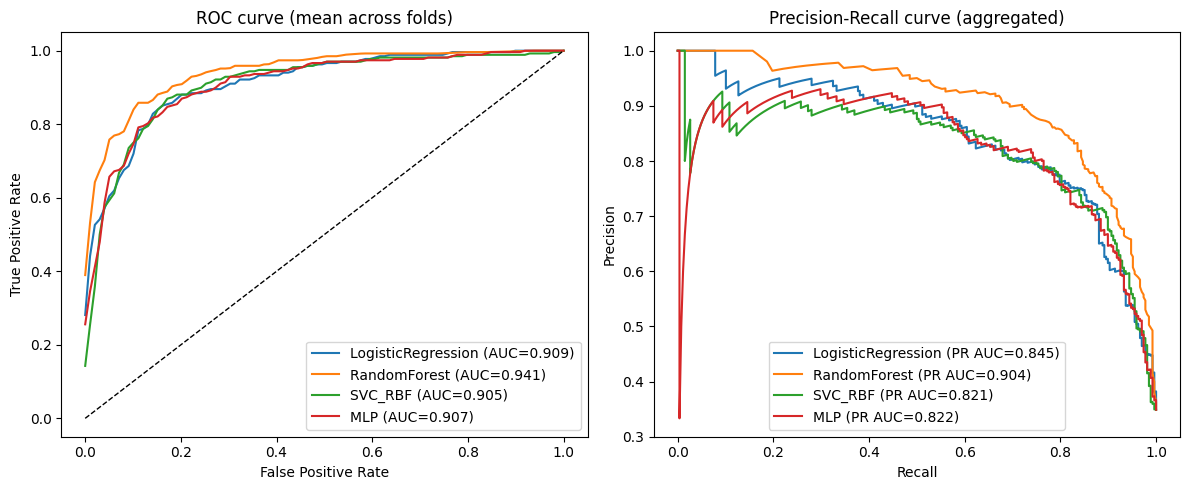

In [13]:
# Plot ROC curves (mean) and Precision-Recall for all models
plt.figure(figsize=(12,5))

# ROC subplot
plt.subplot(1,2,1)
for r in results:
    plt.plot(r['mean_fpr'], r['mean_tpr'], label=f"{r['name']} (AUC={r['mean_auc']:.3f})")
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (mean across folds)")
plt.legend()

# PR subplot
plt.subplot(1,2,2)
for r in results:
    plt.plot(r['pr_recall'], r['pr_precision'], label=f"{r['name']} (PR AUC={r['pr_auc']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve (aggregated)")
plt.legend()

plt.tight_layout()
plt.show()


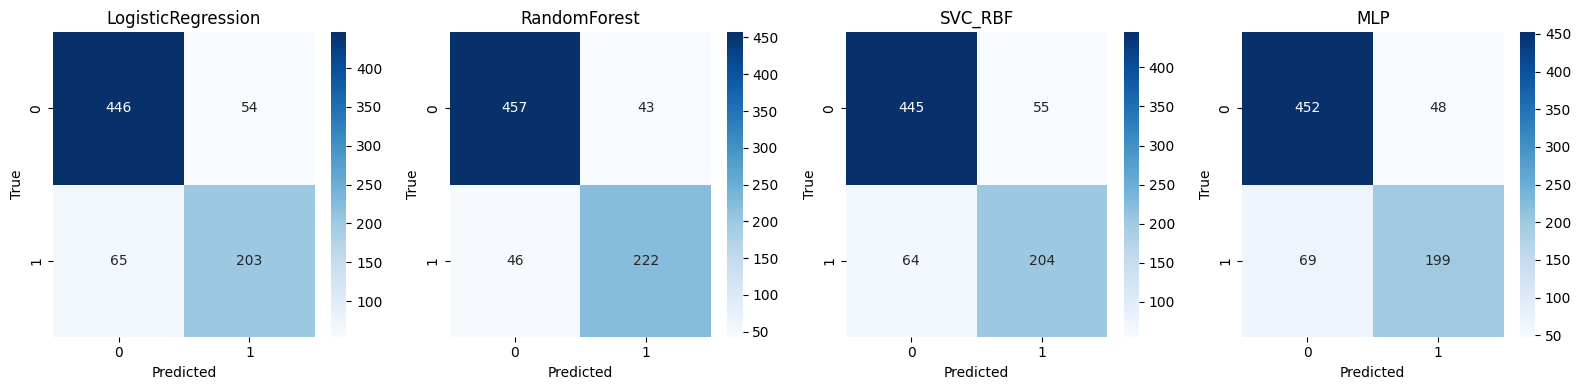

In [14]:
# Confusion matrices plotted for each model
fig, axs = plt.subplots(1, len(results), figsize=(4*len(results),4))
if len(results) == 1:
    axs = [axs]
for ax, r in zip(axs, results):
    sns.heatmap(r['cm'], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(r['name'])
plt.tight_layout()
plt.show()


In [16]:
# Cross-validated scores table (accuracy, precision, recall, f1, roc_auc mean±std)
from sklearn.model_selection import cross_validate

score_names = ['accuracy','precision','recall','f1','roc_auc']
summary_rows = []
for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('clf', model)])
    scores = cross_validate(pipe, X, y, cv=skf, scoring=score_names, n_jobs=-1, return_train_score=False)
    row = {"Model": name}
    for sc in score_names:
        arr = scores['test_'+sc]
        row[sc+'_mean'] = arr.mean()
        row[sc+'_std'] = arr.std()
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
# reorder columns for nicer display
cols_order = ['Model'] + [f"{s}_mean" for s in score_names] + [f"{s}_std" for s in score_names]
summary_df = summary_df[cols_order]
num_cols = summary_df.columns.drop("Model")
summary_df.style.format("{:.3f}", subset=num_cols)



,Model,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,accuracy_std,precision_std,recall_std,f1_std,roc_auc_std
0,LogisticRegression,0.845,0.794,0.758,0.774,0.909,0.019,0.051,0.038,0.024,0.020
1,RandomForest,0.884,0.839,0.829,0.833,0.941,0.018,0.034,0.042,0.027,0.013
2,SVC_RBF,0.845,0.787,0.761,0.774,0.905,0.026,0.033,0.048,0.039,0.014
3,MLP,0.848,0.806,0.743,0.772,0.907,0.030,0.042,0.065,0.047,0.028


In [27]:
#  create hold-out stratified split (80% train, 20% test)
X_raw = X.copy()  # raw DataFrame (not preprocessed) used by pipeline
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.20, stratify=y, random_state=RND
)
print("Train shape:", X_train_raw.shape, "Test shape:", X_test_raw.shape)



Train shape: (614, 11) Test shape: (154, 11)


In [29]:
# prepare parameter distributions for RandomizedSearchCV
rf = RandomForestClassifier(random_state=RND)
rf_param_dist = {
    "n_estimators": sp_randint(50, 400),
    "max_depth": sp_randint(3, 30),
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(1, 20),
    "max_features": ['sqrt', 'log2', None, 0.5, 0.8]
}

lr = LogisticRegression(random_state=RND, solver='liblinear', max_iter=5000)
lr_param_dist = {
    "C": sp_uniform(loc=0.001, scale=100),   # inverse regularization strength
    "penalty": ['l2','l1']  # liblinear supports l1 and l2
}


In [30]:
# RandomizedSearchCV setup and run (Random Forest)
n_iter_search = 20
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

pipe_rf = Pipeline(steps=[('pre', preprocessor), ('clf', rf)])
rand_search_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions={"clf__" + k: v for k,v in rf_param_dist.items()},
    n_iter=n_iter_search,
    scoring='roc_auc',
    cv=cv_inner,
    random_state=RND,
    n_jobs=-1,
    verbose=1
)

t0 = time.time()
rand_search_rf.fit(X_train_raw, y_train)
print("RandomForest search done in {:.1f}s".format(time.time() - t0))
print("Best RF params:", rand_search_rf.best_params_)
print("Best RF CV ROC-AUC:", rand_search_rf.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest search done in 52.8s
Best RF params: {'clf__max_depth': 23, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 4, 'clf__n_estimators': 199}
Best RF CV ROC-AUC: 0.9474598560354373


In [32]:
#RandomizedSearchCV setup and run (Logistic Regression)
pipe_lr = Pipeline(steps=[('pre', preprocessor), ('clf', lr)])
rand_search_lr = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions={"clf__" + k: v for k,v in lr_param_dist.items()},
    n_iter=n_iter_search,
    scoring='roc_auc',
    cv=cv_inner,
    random_state=RND,
    n_jobs=-1,
    verbose=1
)

t0 = time.time()
rand_search_lr.fit(X_train_raw, y_train)
print("LogisticRegression search done in {:.1f}s".format(time.time() - t0))
print("Best LR params:", rand_search_lr.best_params_)
print("Best LR CV ROC-AUC:", rand_search_lr.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogisticRegression search done in 2.8s
Best LR params: {'clf__C': np.float64(5.809361216819947), 'clf__penalty': 'l1'}
Best LR CV ROC-AUC: 0.9052768549280177


In [33]:
# compare best CV scores for tuned models and keep best versions
best_rf_pipe = rand_search_rf.best_estimator_
best_lr_pipe = rand_search_lr.best_estimator_

print("RF best CV ROC-AUC:", rand_search_rf.best_score_)
print("LR best CV ROC-AUC:", rand_search_lr.best_score_)


RF best CV ROC-AUC: 0.9474598560354373
LR best CV ROC-AUC: 0.9052768549280177


In [35]:
#  Refit best models on full training set (they are already refit by RandomizedSearchCV with refit=True)
best_rf_pipe.fit(X_train_raw, y_train)
best_lr_pipe.fit(X_train_raw, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Pregnancies', 'Glucose',
                                                   'BloodPressure',
                                                   'SkinThickness', 'Insulin',
                                                   'BMI',
                                                   'DiabetesPedigreeFunction',
                                                   'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['BMI_CAT', 'INSULIN_CAT',
                                                   'AGE_BIN'])])),
                ('clf',
                 LogisticRegression(C=np.float64(5.809361216819947),
                                    max_iter=5000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [36]:
# Evaluate on hold-out test set (predictions, metrics)
def evaluate_on_test(pipe, X_test, y_test, name="Model"):
    y_proba = pipe.predict_proba(X_test)[:,1]
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba)
    print(f"--- {name} test results ---")
    print(f"Accuracy: {acc:.4f} Precision: {prec:.4f} Recall: {rec:.4f} F1: {f1:.4f} ROC-AUC: {roc:.4f}")
    print("Classification report:\n", classification_report(y_test, y_pred, zero_division=0))
    return dict(y_pred=y_pred, y_proba=y_proba, acc=acc, prec=prec, rec=rec, f1=f1, roc=roc)

rf_test = evaluate_on_test(best_rf_pipe, X_test_raw, y_test, name="Tuned RandomForest")
lr_test = evaluate_on_test(best_lr_pipe, X_test_raw, y_test, name="Tuned LogisticRegression")


--- Tuned RandomForest test results ---
Accuracy: 0.8766 Precision: 0.8182 Recall: 0.8333 F1: 0.8257 ROC-AUC: 0.9565
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       100
           1       0.82      0.83      0.83        54

    accuracy                           0.88       154
   macro avg       0.86      0.87      0.87       154
weighted avg       0.88      0.88      0.88       154

--- Tuned LogisticRegression test results ---
Accuracy: 0.8506 Precision: 0.7818 Recall: 0.7963 F1: 0.7890 ROC-AUC: 0.9228
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88       100
           1       0.78      0.80      0.79        54

    accuracy                           0.85       154
   macro avg       0.84      0.84      0.84       154
weighted avg       0.85      0.85      0.85       154



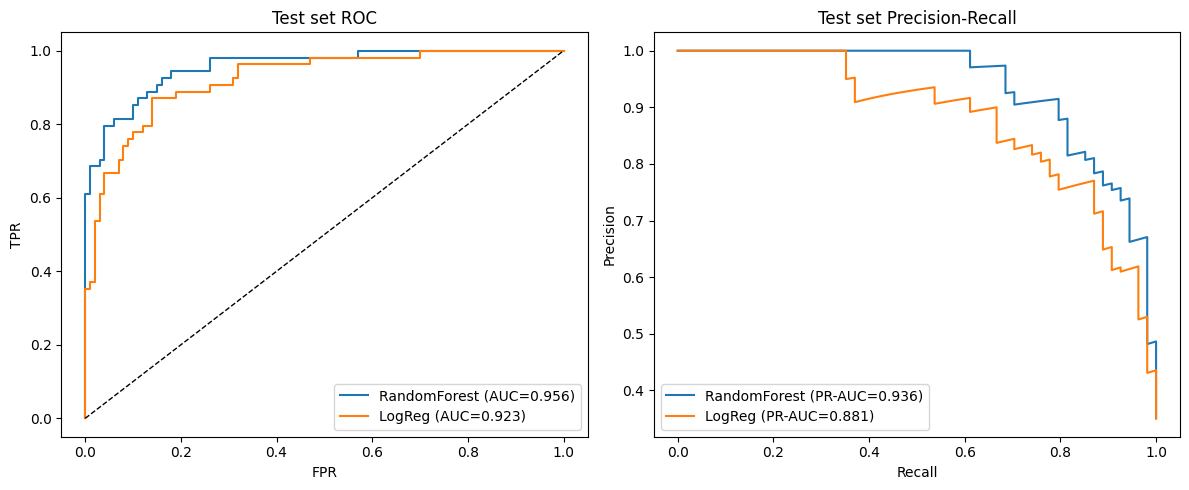

In [37]:
# Test-set ROC and PR plots for the two tuned models
plt.figure(figsize=(12,5))

# RF ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test['y_proba'])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# LR ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_test['y_proba'])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.subplot(1,2,1)
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_rf:.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_lr:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Test set ROC")
plt.legend()

# PR plot
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_test['y_proba'])
precision_lr, recall_lr, _ = precision_recall_curve(y_test, lr_test['y_proba'])
pr_auc_rf = auc(recall_rf, precision_rf)
pr_auc_lr = auc(recall_lr, precision_lr)

plt.subplot(1,2,2)
plt.plot(recall_rf, precision_rf, label=f"RandomForest (PR-AUC={pr_auc_rf:.3f})")
plt.plot(recall_lr, precision_lr, label=f"LogReg (PR-AUC={pr_auc_lr:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test set Precision-Recall")
plt.legend()

plt.tight_layout()
plt.show()


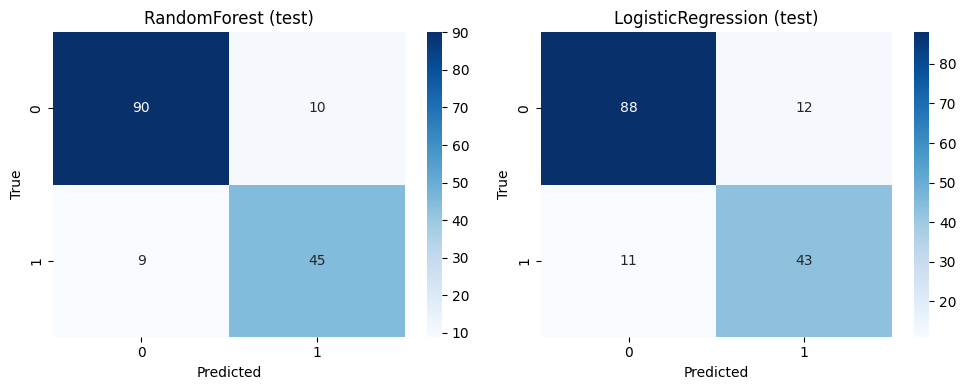

In [38]:
# Test-set confusion matrices for tuned models
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(confusion_matrix(y_test, rf_test['y_pred']), annot=True, fmt='d', ax=axs[0], cmap='Blues')
axs[0].set_title('RandomForest (test)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(confusion_matrix(y_test, lr_test['y_pred']), annot=True, fmt='d', ax=axs[1], cmap='Blues')
axs[1].set_title('LogisticRegression (test)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()


In [39]:
#  Feature importance (Random Forest) — map to feature names from preprocessor
# Get feature names function
def get_feature_names_from_preprocessor(preprocessor, numeric_cols, cat_cols):
    """Return list of output feature names after ColumnTransformer with OneHotEncoder(drop='first')"""
    names = []
    # numeric names
    names.extend(numeric_cols)
    # categorical OHE names
    if cat_cols:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        ohe_names = list(ohe.get_feature_names_out(cat_cols))
        names.extend(ohe_names)
    return names

feature_names = get_feature_names_from_preprocessor(preprocessor, numeric_cols, cat_cols)
len(feature_names), feature_names[:10]


(14,
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age',
  'BMI_CAT_Obese',
  'BMI_CAT_Over Weight'])

,0
Insulin,0.478773
INSULIN_CAT_Normal,0.188391
Glucose,0.114419
SkinThickness,0.083200
Age,0.051435
DiabetesPedigreeFunction,0.022971
BMI,0.019190
BloodPressure,0.015552
Pregnancies,0.011803
AGE_BIN_Young,0.009805


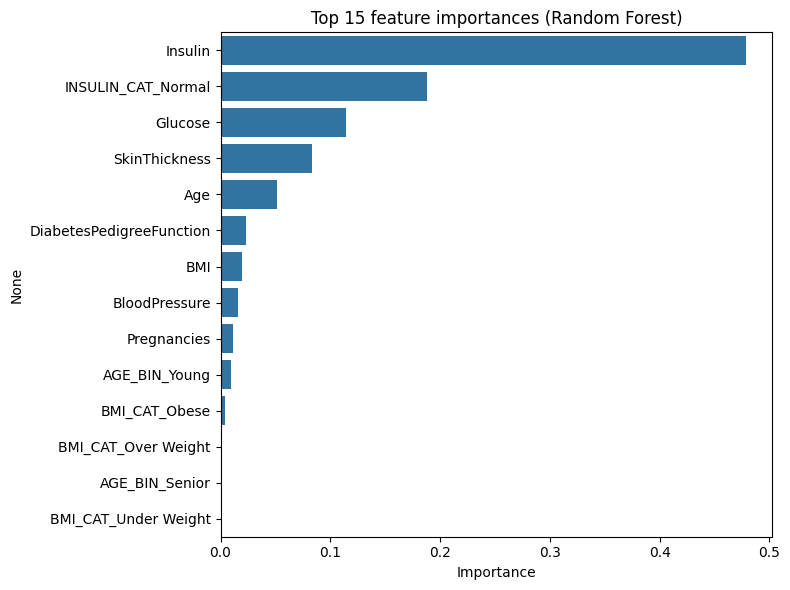

In [40]:
#  extract RF feature importances and show top 15
rf_clf = best_rf_pipe.named_steps['clf']
# in rare cases pipeline stores classifier differently; guard:
if hasattr(rf_clf, "feature_importances_"):
    importances = rf_clf.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    display(feat_imp.head(15))
    plt.figure(figsize=(8,6))
    sns.barplot(x=feat_imp.head(15).values, y=feat_imp.head(15).index)
    plt.title("Top 15 feature importances (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest classifier does not expose feature_importances_.")


Top negative coefficients (predict class 0 bias):


,0
INSULIN_CAT_Normal,-3.140033
Insulin,-0.583633
AGE_BIN_Young,-0.567745
AGE_BIN_Senior,-0.118392
BloodPressure,-0.041803
Age,-0.008944
BMI_CAT_Under Weight,0.000000
DiabetesPedigreeFunction,0.137386
SkinThickness,0.208766
Pregnancies,0.296643


Top positive coefficients (predict class 1 bias):


,0
Glucose,1.057040
BMI_CAT_Obese,1.051995
BMI_CAT_Over Weight,0.745773
BMI,0.323750
Pregnancies,0.296643
SkinThickness,0.208766
DiabetesPedigreeFunction,0.137386
BMI_CAT_Under Weight,0.000000
Age,-0.008944
BloodPressure,-0.041803


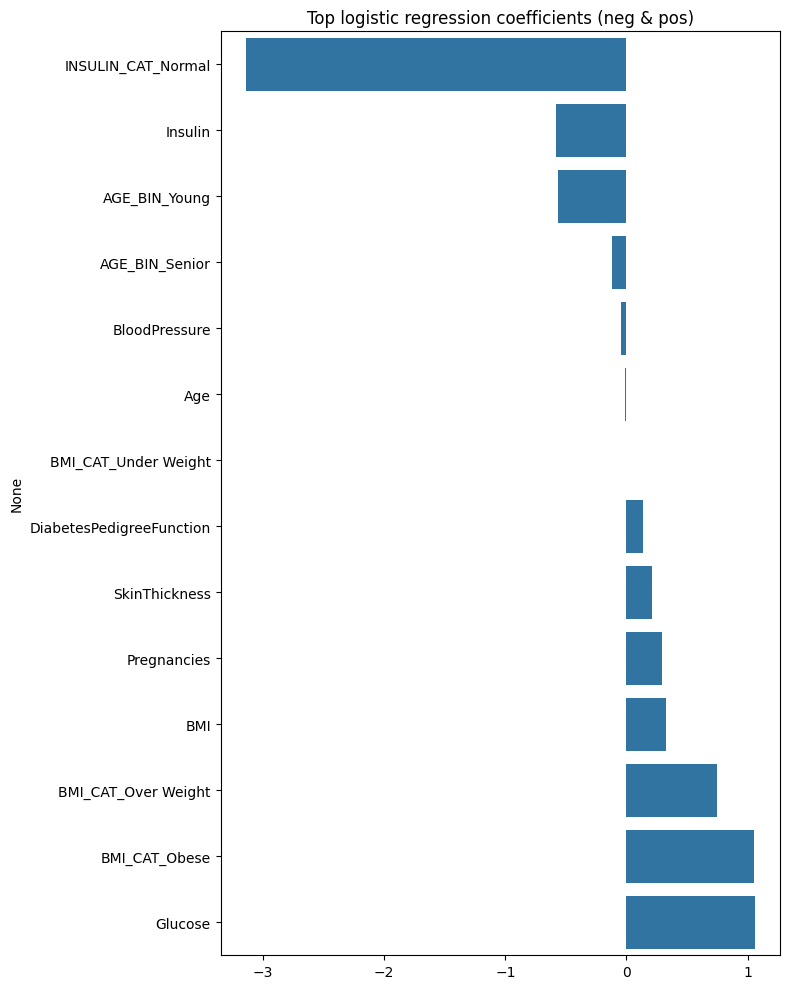

In [41]:
# Logistic Regression coefficients (odds direction) — show top positive/negative coefficients
lr_clf = best_lr_pipe.named_steps['clf']
if hasattr(lr_clf, "coef_"):
    coefs = lr_clf.coef_.ravel()
    coef_ser = pd.Series(coefs, index=feature_names).sort_values()
    print("Top negative coefficients (predict class 0 bias):")
    display(coef_ser.head(10))
    print("Top positive coefficients (predict class 1 bias):")
    display(coef_ser.tail(10)[::-1])
    # plot
    plt.figure(figsize=(8,10))
    coef_ser_to_plot = pd.concat([coef_ser.head(10), coef_ser.tail(10)])
    sns.barplot(x=coef_ser_to_plot.values, y=coef_ser_to_plot.index)
    plt.title("Top logistic regression coefficients (neg & pos)")
    plt.tight_layout()
    plt.show()
else:
    print("Logistic Regression has no coef_ attribute available.")


In [42]:
# export tuned results summary for report
final_summary = pd.DataFrame([{
    "Model":"RandomForest (tuned)",
    "Accuracy": rf_test['acc'],
    "Precision": rf_test['prec'],
    "Recall": rf_test['rec'],
    "F1": rf_test['f1'],
    "ROC_AUC": rf_test['roc']
},{
    "Model":"LogisticRegression (tuned)",
    "Accuracy": lr_test['acc'],
    "Precision": lr_test['prec'],
    "Recall": lr_test['rec'],
    "F1": lr_test['f1'],
    "ROC_AUC": lr_test['roc']
}])
display(final_summary)
# Optionally save CSV
final_summary.to_csv("stage2_tuned_test_summary.csv", index=False)
print("Saved: stage2_tuned_test_summary.csv")


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,RandomForest (tuned),0.876623,0.818182,0.833333,0.825688,0.956481
1,LogisticRegression (tuned),0.850649,0.781818,0.796296,0.788991,0.922778


Saved: stage2_tuned_test_summary.csv
